# Deploy a trained Keras MobileNet V2 model with Tensorflow Servning

I am going to walk you through a complete a guideline of how to:

**Part 1:**
- Prepare data for training 
- Trained a deep learning model

**Part 2:**
- Serve the model with Tensorflow serving.
- Deploy to [Heroku](https://www.heroku.com/).

**In order to fully benefits from this services:**
- You should be familiar with python.
- You should have some understanding of what deep learning and neural network is.

**Here is the list of what I am going to use:**
- [Keras 2.2](https://keras.io/)
- [Tensorflow 1.11](https://www.tensorflow.org/)
- [Python 3.6](https://www.python.org/downloads/release/python-367/)
- [scikit-image 0.14](https://scikit-image.org/)
- [scikit-learn 0.19](http://scikit-learn.org/)


# Helper functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def show_images(images):
    """
    images : numpy arrays
    """
    n_images = len(images)
    titles = ['(%d)' % i for i in range(1, n_images + 1)]
    num = 5
    iter_num = np.ceil(n_images / num).astype(int)
    for i in range(iter_num):
        fig = plt.figure()
        sub_images = images[i * num:num * (i + 1)]
        sub_titles = titles[i * num:num * (i + 1)]
        for n, (image, title) in enumerate(zip(sub_images, sub_titles)):
            a = fig.add_subplot(1, np.ceil(len(sub_images)), n + 1)
            if image.ndim == 2:
                plt.gray()
            a.set_title(title, fontsize=15)
            plt.imshow(image)


## Prepare data for training

For the sake of simplicity, I am going to use the fashion mnist dataset because it is already optimized and labeled for a classification problem. 
Read more about the Fashion-MINST dataset in this paper [here](https://arxiv.org/abs/1708.07747)
To download dataset and check other examples [here](https://github.com/zalandoresearch/fashion-mnist)

It has 70,000 images, and each image is a grayscale of the size (28X28). 
which are categories into the following:

|Lable|Description|  
|-  |      -      |
| 0 | T-shirt/top | 
| 1 | Trouser     | 
| 2 | Pullover    |  
| 3 | Dress       | 
| 4 | Coat        | 
| 5 | Sandal      | 
| 6 | Shirt       |
| 7 | Sneaker     | 
| 8 | Bag         | 
| 9 | Ankle boot  | 


Let's start downloading the dataset. 
fortunately, many deep learning (DL) frameworks support fashion mnist dataset out of the box, 
including keras in our case.

In [2]:
import keras

# Load the fashion-mnist train data and test data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)



/Users/MoAir/anaconda/envs/g/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


x_train shape: (60000, 28, 28) y_train shape: (60000,)


### Show samples of data

In [ ]:
show_images(x_train[:10])

By default `keras.datasets.fashion_mnist.load_data()` is returning training and testing dataset. 
It is essential to split the dataset into training and  testing. 
Train data: This data actually to train the neural network (NN) 
Test: To valid the NN during the traning phase, by tuning and re-adjust the hyperparameters. 
hyperparameter is a parameter whose value is set before the learning process begins.(we will see them later)

**However sometime we see train, valid and test dataset, why?**

Glad you ask!

After training the NN, we run the training NN against a our validation dataset 
to make sure that the model is generalized and is not overfitting. Overfitting basically means a model only predict the right result with the training data. However, if a model predicts the incorrectly result for the training data it's called underfitting. Here is a nice explination of [overfitting and underfitting](https://medium.com/greyatom/what-is-underfitting-and-overfitting-in-machine-learning-and-how-to-deal-with-it-6803a989c76).


If the validation result was not pleased, we retrain the NN with different hyperparameters and we repeat this until we reach to a satisfied result. Now if the tranined and validation dataset have the result or score we want, we would think we are done. Not so fast!. Since we adjust the hyperparameters, we could lead the model to overfit in both train and valid dataset. To avoid this, we split the dataset into Train, Valid, and Test. 
After getting the desired score in both train and valid data, we run the model against the test dataset. Usually the test dataset should be closed to the validation result. For example getting 90% in valid data, and 87% in testing is acceptable.

### Data normalization
Normalize the data dimensions so that they are of approximately the same scale.In general, normalization makes very deep NN easier to train, special in Convolutional and Recurrent neural network.

Here is a nice explanation [video](https://www.coursera.org/lecture/deep-neural-network/normalizing-activations-in-a-network-4ptp2) and an [article](https://medium.com/@darrenyaoyao.huang/why-we-need-normalization-in-deep-learning-from-batch-normalization-to-group-normalization-d06ea0e59c17)

In [ ]:
norm_x_train = x_train.astype('float32') / 255
norm_x_test = x_test.astype('float32') / 255
# dsiplay images
show_images(norm_x_train[:10])

### Convert labels (y_train and y_test) to one hot encoding
A one hot encoding is a representation of categorical variables as binary vectors.

[Here is the full explanation](https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/)

In [ ]:
encoded_y_train = keras.utils.to_categorical(y_train, num_classes=10, dtype='float32')
encoded_y_test = keras.utils.to_categorical(y_test, num_classes=10, dtype='float32')


### Resize images

Because we are going to use [MobileNet V2](https://keras.io/applications/#mobilenetv2) model, which accept (96 , 96 ,3) format as minimum image size.

We need to resize the image and convert to 3 channel (RGB.
from (28 X 28) to (96 X 96 X 3). 

Here are the supported formats;
> If imagenet weights are being loaded, input must have a static square shape(one of (96, 96), (128, 128), (160, 160),(192, 192), or (224, 224)).

In [3]:
from skimage.transform import resize

target_size = 96
def preprocess_image(x):
    # convert to 3 channel
    x = resize(x, (target_size, target_size),
            mode='constant',
            anti_aliasing=False)
    x = np.stack((x,)*3, axis=-1) 
    return x.astype(np.float32)
    

If we resize all the training and testing data, it will eat up a lot of memory resources; therefore, we are going to use generator.   
[Python Generators](https://www.programiz.com/python-programming/generator) are a simple way of creating iterators. 

In [ ]:
from sklearn.utils import shuffle

def load_data_generator(x,y, batch_size=64):
    num_samples = x.shape[0]
    while 1:  # Loop forever so the generator never terminates
        try:
            shuffle(x)
            for offset in range(0, num_samples, batch_size):
                x_data =  [preprocess_image(img) for img in x[offset:offset + batch_size]]
                y_data = y[offset:offset + batch_size]
                # convert to numpy array since this what keras required
                yield shuffle(np.array(x_data), np.array(y_data))
        except Exception as err:
            print(err)

## Train a deep learning Model

### Transfer Learning
Transfer learning in deep learning means to transfer knownlady from one domain to another similar one.
In our example, I have chosen MobileNet V2 model because it’s faster to train and small in size. [Documentation for Individual Models](https://keras.io/applications/#documentation-for-individual-models).
MobileNet is pre-trained with [ImageNet dataset](http://www.image-net.org/) with 1000 classes or categories. 
We are using this model and re-train it with our dataset and 10 classes only. Because we are using pre-trained model that has been trained on different dataset (domain), then we are using transfer learning :). Here is a nice article example it in more details. [A Gentle Introduction to Transfer Learning for Deep Learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)


We can freez the MobileNet trained layers and only trained the layers we added. 
by the following:
```
for layer in app_model.layers:
        layer.trainable = False 
```

**When do I need to re-train the trainable layers?**   
When you have large dataset to train, in our case we just have enough data, however,    
I trained with `layer.trainable = True` you can try the other way around and see the result.


In [ ]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.layers import Dense, Input, Dropout
from keras.models import Model

def build_model( ):
    input_tensor = Input(shape=(target_size, target_size, 3))
    app_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=input_tensor,
        input_shape=(target_size, target_size, 3),
        pooling='avg')

    for layer in app_model.layers:
        layer.trainable = True  # trainable has to be false in order to freez the layers
        
    op = Dense(256, activation='relu')(app_model.output)
    op = Dropout(.25)(op)
    outputs = Dense(10, activation='softmax')(op)

    model = Model(inputs=input_tensor, outputs=outputs)


    return model


### Build and compile the model
The most interesting thing in our model is the last layer
```
 outputs = Dense(10, activation='softmax')(op)
```
10 indicates that the final result should have a change of (10,) which reprease our 10 classes

**softmax:** calculates a probability for every possible class.   
**activation='softmax'**: return the highest probability;    
for example, if `Coat` is the highest probability then the result would be something like [0,0,0,0,1,0,0,0,0,0] with `1` in index 5 indicate `Coat`.


In [ ]:
model = build_model()
model.compile(optimizer=keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

### Train
Now we are ready to train the model.

**epochs**: 
 > One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE. [1]

**Batch Size**
> Total number of training examples present in a single batch.[1]


In [ ]:
train_generator = load_data_generator(norm_x_train, encoded_y_train, batch_size=64)

model.fit_generator(
    generator=train_generator,
    steps_per_epoch=900,
    verbose=1,
    epochs=5)

### Test

In [ ]:
test_generator = load_data_generator(norm_x_test, encoded_y_test, batch_size=64)
model.evaluate_generator(generator=test_generator,steps=900,verbose=1)

## Save model
Save the model to be reused in part 2.

In [6]:
model_name = "tf_servning_keras_mobilenetv2"
model.save(f"models/{model_name}.h5")

(for medium only)
# Conclusion 
In the end of this part, here what we have learning.
We were able to prepare a the fashion dataset for MobileNetV2 model. 
And use MobileNet as our base model for transfer learning.
And we got `94%` accuracy in training and  `86%` accuracy in testing.
In part 2 we are going save the model to a format the tensorflow serving can read. 
and then deploy to heroku. Thank you for ready and If you have any question or suggests, 
please leave them down in the comments


## Part 2

## Makes Model ready to tensorflow serving

### Tensorflow serving 
[TensorFlow Serving](https://www.tensorflow.org/serving/overview) is a flexible, high-performance serving system for machine learning models, designed for **production** environments.


#### Load the saved model from Part 1


In [4]:
from keras.models import load_model
model = load_model(f"models/{model_name}.h5")

### Build & Save model to be tensorflow serving ready


In [7]:
import os
import tensorflow as tf
# Import the libraries needed for saving models
# Note that in some other tutorials these are framed as coming from tensorflow_serving_api which is no longer correct
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import tag_constants, signature_constants, signature_def_utils_impl

# images will be the input key name
# scores will be the out key name
prediction_signature = tf.saved_model.signature_def_utils.predict_signature_def(
    {
    "images": model.input
    }, {
    "scores": model.output
    })

# export_path is a directory in which the model will be created
export_path = os.path.join(
    tf.compat.as_bytes('models/export/{}'.format(model_name)),
    tf.compat.as_bytes('1'))

builder = saved_model_builder.SavedModelBuilder(export_path)

sess = keras.backend.get_session()

# Add the meta_graph and the variables to the builder
builder.add_meta_graph_and_variables(
    sess, [tag_constants.SERVING],
    signature_def_map={
        'prediction': prediction_signature,
    })
# save the graph
builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/export/tf_servning_keras_mobilenetv2/1/saved_model.pb


b'models/export/tf_servning_keras_mobilenetv2/1/saved_model.pb'

## Setting up Heroku & Docker
Nice work, almost there, now we are going to deploy our model to heroku, 
so we can call it.

[Heroku](https://www.heroku.com/) is a cloud platform as a service supporting several programming languages.
[docker]() allows us to package all the necessary libraries and programer into a container. Here is a nice [Introduction to Containers, VMs and Docker](https://medium.freecodecamp.org/a-beginner-friendly-introduction-to-containers-vms-and-docker-79a9e3e119b)


- [Install docker for macOS and windows](https://www.docker.com/products/docker-desktop)
- A little more work for Ubuntu users but still straightforward [Install docker for Ubuntu](https://docs.docker.com/install/linux/docker-ce/ubuntu/#upgrade-docker-ce)
- [Signup to Heroku](https://signup.heroku.com/)
- [Install heroku-cli](https://devcenter.heroku.com/articles/heroku-cli#download-and-install)

### After you have installed docker and heroku-cli.

Run the following to make sure docker & heroku have been installed correctly
```
> docker ps 
CONTAINER ID IMAGE COMMAND CREATED STATUS PORTS NAMES

> heroku --version
heroku/7.18.3 darwin-x64 node-v10.12.0

# make sure to loign to your heroku account
heroku login
# Output should have:   
Logged in as xxxxx@xxx.xx
```


### Deploy the model to Heroku

#### Download tensorflow serving image from `hub.docker.com`
Because tensorflow serving docker image was not optimized for heroku. 

I have created a dockerfile that following heroku instructure.
cleck [here](https://github.com/malnakli/ML/tf_servning_keras_mobilenetv2/Dockerfile) to look at.
Also I have pushed the a docker image that ready to deply to heroku, which already have the trained model. 
`docker pull malnakli/ml:tf-serving-heroku-1.11`

However, I will walk you through how to do build the image that has your trained model

Run the following:
`docker build -t tf-serving-heroku-1.11 .`

Once the image build. you can run it locally.
`docker run -p 8501:8501 -e PORT=8501 -t tf-serving-heroku-1.11`

If you see the following the last output, then it works.
```
2018-10-27 21:17:47.515120: I tensorflow_serving/model_servers/server.cc:301] Exporting HTTP/REST API at:localhost:8501 ...
```
#### Deploy

##### Log in to Container Registry:
`heroku container:login`

##### Create a heroku app
`heroku create ${YOUR_APP_NAME}`

#### Push the docker image to heroku
`heroku  container:push web -a ${YOUR_APP_NAME}`   
`heroku container:release web -a ${YOUR_APP_NAME}`

### Call the model
Tensorflow serving RESTful API syntax as following:
```
POST http://host:port/<URI>:<VERB>

URI: /v1/models/${MODEL_NAME}[/versions/${MODEL_VERSION}]
VERB: classify|regress|predict
```
And you can see the full documentation about RESTful API in [Here](https://www.tensorflow.org/serving/api_rest). 

In our case the reqest will look like as:

> `http://localhost:8501//v1/models/tf_servning_keras_mobilenetv2/versions/1:predict`

Keep in mind that JSON data sent to TensorFlow Model Server has to be structured in a very particular way
```
{
  // (Optional) Serving signature to use.
  // If unspecifed default serving signature is used.
  "signature_name": <string>,

  // Input Tensors in row ("instances") or columnar ("inputs") format.
  // A request can have either of them but NOT both.
  "instances": <value>|<(nested)list>|<list-of-objects>
  "inputs": <value>|<(nested)list>|<object>
}
```

Now I will show you how we can call the model. However, before calling our model, we need to resize the image and convert them no float32 image_preprcess(image) function from part 1


(96, 96, 3)


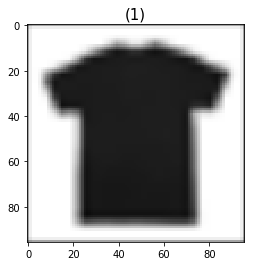

In [26]:
from urllib import request
from PIL import Image

image_url = "https://cdn.shopify.com/s/files/1/2029/4253/products/Damb_Back_2a3cc4cc-06c2-488e-8918-2e7a1cde3dfc_530x@2x.jpg"
image_path = f"tmp/{image_url.split('/')[-1]}"
# download image
with request.urlopen(url=image_url, timeout=10) as response:
    data = response.read()
    with open(image_path, 'wb') as f:
        f.write(data)

# convert image to grayscale.
image = Image.open(image_path).convert('L')
# resize the image to 28 28 to make sure it is similar to our dataset
image.thumbnail((28,28))
image = preprocess_image(np.array(image))
print(image.shape)
show_images([image])

Our finall call in `curl` will look like as:
```
curl -X POST \
  https:// ${YOUR_APP_NAME}.herokuapp.com/v1/models/tf_servning_keras_mobilenetv2/versions/1:predict  \
  -d '{"signature_name":"prediction","instances":[{"images":image.tolist()}]}'
```

In [31]:
import requests
import json
# change https://tf-servning-keras-mobilenetv2.herokuapp.com to your url or 
# if you ran the docker locally, then replace with http://localhost:8501
url = f"https://tf-servning-keras-mobilenetv2.herokuapp.com/v1/models/tf_servning_keras_mobilenetv2/versions/1:predict"
data = {"signature_name":"prediction",
        "instances":[{"images":image.tolist()}]}
data = json.dumps(data)


In [33]:
import sys
labels = ['T-shirt/top' ,'Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag', 'Ankle boot']
try:
    response = requests.post(url,data=data)
    response = response.json()
    highest_index = np.argmax(response['predictions'])
    print(labels[highest_index])
except:
    print(sys.exc_info()[0])

T-shirt/top


for medium only
# Conclusion 

### TODO 
Thank you for ready and If you have any question or suggests, 
please leave them down in the comments

# References:
- [1] https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9
- https://medium.com/@tmlabonte/serving-image-based-deep-learning-models-with-tensorflow-servings-restful-api-d365c16a7dc4